In [1]:
# -*- coding: utf-8 -*-
"""
@Time ： 2023/7/21 下午8:51
@Auth ： zhangtao
@File ：train_bert-bilstm-crf_ner.py
@IDE ：PyCharm
@Desc:
"""
import pandas as pd
import numpy as np
from pytorch_pretrained_bert import BertModel
from torchcrf import CRF
from tqdm import tqdm, trange
import torch
import pickle
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
import transformers
from seqeval.metrics import f1_score, accuracy_score, recall_score, precision_score
from transformers import BertModel, BertConfig
from seqeval.metrics import accuracy_score, f1_score, classification_report
from transformers import WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
from transformers.models.bert.modeling_bert import BertPreTrainedModel
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

/home/zhangtao/anaconda3/envs/env3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:

print(torch.__version__)
print(transformers.__version__)


def vet_frases(dataframe):
    sentences = []
    sentences_aux = []
    labels = []
    labels_aux = []
    for word, label in zip(dataframe.word.values, dataframe.label.values):
        if (word == ''):
            continue
        sentences_aux.append(word)
        labels_aux.append(label)
        if (word == '.'):
            sentences.append(sentences_aux)
            labels.append(labels_aux)

            sentences_aux = []
            labels_aux = []
    return sentences, labels


def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []
    for word, label in zip(sentence, text_labels):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


class BertBilstmCrfForNer(BertPreTrainedModel):
    def __init__(self, config):
        super(BertBilstmCrfForNer, self).__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.bilstm = nn.LSTM(config.hidden_size, config.hidden_size // 2, num_layers=2, bidirectional=True,
                              batch_first=True)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.crf = CRF(num_tags=config.num_labels, batch_first=True)
        self.init_weights()

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        sequence_output, _ = self.bilstm(sequence_output)
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        outputs = (logits,)
        if labels is not None:
            loss = self.crf(emissions=logits, tags=labels, mask=attention_mask)
            outputs = (-1 * loss,) + outputs
        return outputs  # (loss), scores


MAX_LEN = 128
bs = 5
epochs = 20
max_grad_norm = 1.0

# 打开文件
with open("2023-data/train.txt", "r") as file:
    # 读取文件内容
    lines = file.readlines()
# 分割每行并创建 DataFrame
train = [line.strip().split("   ") for line in lines]
train = pd.DataFrame(train, columns=["word", "label"]).fillna('')

with open("2023-data/dev.txt", "r") as file:
    # 读取文件内容
    lines = file.readlines()
# 分割每行并创建 DataFrame
devel = [line.strip().split("   ") for line in lines]
devel = pd.DataFrame(devel, columns=["word", "label"]).fillna('')

with open("2023-data/test.txt", "r") as file:
    # 读取文件内容
    lines = file.readlines()
# 分割每行并创建 DataFrame
test = [line.strip().split("   ") for line in lines]
test = pd.DataFrame(test, columns=["word", "label"]).fillna('')
print("train", train)

# creat dataset
train_sentences, train_labels = vet_frases(train)
print(train_sentences[0])
print(train_labels[0])
test_sentences, test_labels = vet_frases(test)
print(test_sentences[0])
print(test_labels[0])
devel_sentences, devel_labels = vet_frases(devel)
print(devel_sentences[0])
print(devel_labels[0])

# creat label
tag_values = list(set(train["label"].values))
tag_values.append("PAD")
tag_values = [x for x in tag_values if x]
print(sorted(tag_values))
tag2idx = {t: i for i, t in enumerate(tag_values)}
print(len(tag_values))

# set GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("torch.cuda.get_device_name(0)", torch.cuda.get_device_name(0))

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

train_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train_sentences, train_labels)
]
test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_sentences, test_labels)
]
devel_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(devel_sentences, devel_labels)
]
print(train_tokenized_texts_and_labels[0])

train_tokenized_texts = [token_label_pair[0] for token_label_pair in train_tokenized_texts_and_labels]
train_labels = [token_label_pair[1] for token_label_pair in train_tokenized_texts_and_labels]
test_tokenized_texts = [token_label_pair[0] for token_label_pair in test_tokenized_texts_and_labels]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_texts_and_labels]
devel_tokenized_texts = [token_label_pair[0] for token_label_pair in devel_tokenized_texts_and_labels]
devel_labels = [token_label_pair[1] for token_label_pair in devel_tokenized_texts_and_labels]
print(train_tokenized_texts[0])

train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized_texts],
                                maxlen=MAX_LEN, dtype="long", value=0.0,
                                truncating="post", padding="post")
test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                               maxlen=MAX_LEN, dtype="long", value=0.0,
                               truncating="post", padding="post")
devel_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in devel_tokenized_texts],
                                maxlen=MAX_LEN, dtype="long", value=0.0,
                                truncating="post", padding="post")
train_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in train_labels],
                           maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                           dtype="long", truncating="post")
test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                          maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                          dtype="long", truncating="post")
devel_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in devel_labels],
                           maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                           dtype="long", truncating="post")
train_attention_masks = [[float(i != 0.0) for i in ii] for ii in train_input_ids]
test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]
devel_attention_masks = [[float(i != 0.0) for i in ii] for ii in devel_input_ids]
tr_inputs, tr_tags, tr_masks = shuffle(train_input_ids, train_tags, train_attention_masks, random_state=2020)
val_inputs, val_tags, val_masks = shuffle(devel_input_ids, devel_tags, devel_attention_masks, random_state=2020)
test_inputs, test_tags, test_masks = shuffle(test_input_ids, test_tags, test_attention_masks, random_state=2020)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
test_inputs = torch.tensor(test_inputs)
test_tags = torch.tensor(test_tags)
test_masks = torch.tensor(test_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

# creat model
config = BertConfig.from_pretrained("bert-base-cased", num_labels=len(tag2idx), output_attentions=False,
                                    output_hidden_states=False)
model = BertBilstmCrfForNer.from_pretrained(
    "bert-base-cased",
    config=config
)

model.cuda()
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
validation_accuracy, validation_f1 = [], []
validation_recall, validation_precision = [], []
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1].to(torch.bool), "token_type_ids": None,
                  "labels": batch[2]}
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(**inputs)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print()
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1].to(torch.bool), "token_type_ids": None,
                  "labels": batch[2]}

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(**inputs)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    print("Validation loss: {}".format(eval_loss))
    validation_loss_values.append(eval_loss)
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation Recall: {}".format(recall_score(pred_tags, valid_tags)))
    print("Validation Precision: {}".format(precision_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    validation_accuracy.append(accuracy_score(pred_tags, valid_tags))
    validation_f1.append(f1_score(pred_tags, valid_tags))
    validation_recall.append(recall_score(pred_tags, valid_tags))
    validation_precision.append(precision_score(pred_tags, valid_tags))
result_data = {'train_loss': loss_values, 'val_loss': validation_loss_values, 'val_f1': validation_f1,
               'val_pre': validation_precision, 'val_recall': validation_recall}
# 保存数据到文件
with open('save_model/bert-bilstm-crf_metrics.pkl', 'wb') as file:
    pickle.dump(result_data, file)
model.save_pretrained("save_model/bert-bilstm-crf_model_ner")

# # 从文件中加载数据
# with open('metrics.pkl', 'rb') as file:
#     loaded_data = pickle.load(file)
#
# # 获取加载后的数据
# f1_list = loaded_data['f1']
# loss_list = loaded_data['loss']
#
# # 打印加载后的数据
# print(f1_list)
# print(loss_list)

1.7.1
4.29.2
train                    word label
0         [Implantation     O
1                    of     O
2               newborn     O
3                  mice     O
4                  skin     O
...                 ...   ...
79287               and     O
79288  Wnt/beta-catenin     O
79289         signaling     O
79290                 .     O
79291                        

[79292 rows x 2 columns]
['[Implantation', 'of', 'newborn', 'mice', 'skin', 'cells', 'with', 'chamber', 'method', 'to', 'construct', 'a', 'model', 'of', 'hair', 'follicle', 'development]', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O']
['Induction', 'of', 'hair', 'follicle', 'neogenesis', 'with', 'cultured', 'mouse', 'dermal', 'papilla', 'cells', 'in', 'de', 'novo', 'regenerated', 'skin', 'tissues', '.']
['O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertBilstmCrfForNer: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertBilstmCrfForNer from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertBilstmCrfForNer from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertBilstmCrfForNer were not initialized from the model checkpoint at bert-base-cased and are newly initialized


Average train loss: 36.58694519346742
Validation loss: 14.660040383387093
Validation Accuracy: 0.9760130022978198
Validation Recall: 0.734717416378316
Validation Precision: 0.8381578947368421
Validation F1-Score: 0.7830362630608481



Epoch:   5%|▌         | 1/20 [03:21<1:03:39, 201.02s/it]


Average train loss: 18.655622523192424
Validation loss: 19.376313315497505
Validation Accuracy: 0.9727063834556969
Validation Recall: 0.7019438444924406
Validation Precision: 0.8552631578947368
Validation F1-Score: 0.7710557532621588



Epoch:  10%|█         | 2/20 [06:34<58:56, 196.47s/it]  


Average train loss: 15.108736873585816
Validation loss: 20.449145577170633
Validation Accuracy: 0.9793196211399429
Validation Recall: 0.7960829493087558
Validation Precision: 0.9092105263157895
Validation F1-Score: 0.8488943488943489



Epoch:  15%|█▌        | 3/20 [10:04<57:28, 202.88s/it]


Average train loss: 14.432689657985343
Validation loss: 17.77555889553494
Validation Accuracy: 0.9814493078518186
Validation Recall: 0.8325358851674641
Validation Precision: 0.9157894736842105
Validation F1-Score: 0.8721804511278196



Epoch:  20%|██        | 4/20 [13:25<53:54, 202.17s/it]


Average train loss: 12.550830965202763
Validation loss: 27.07834999007408
Validation Accuracy: 0.9756206915877375
Validation Recall: 0.765625
Validation Precision: 0.9026315789473685
Validation F1-Score: 0.8285024154589372



Epoch:  25%|██▌       | 5/20 [16:50<50:47, 203.16s/it]


Average train loss: 10.8618684435694
Validation loss: 21.941433453800702
Validation Accuracy: 0.9838031721123129
Validation Recall: 0.8573248407643312
Validation Precision: 0.8855263157894737
Validation F1-Score: 0.8711974110032362



Epoch:  30%|███       | 6/20 [20:17<47:39, 204.23s/it]


Average train loss: 9.30752693310631
Validation loss: 27.334383299856476
Validation Accuracy: 0.979599843075716
Validation Recall: 0.7981438515081206
Validation Precision: 0.9052631578947369
Validation F1-Score: 0.8483353884093712



Epoch:  35%|███▌      | 7/20 [23:34<43:47, 202.15s/it]


Average train loss: 6.946815029220231
Validation loss: 32.710660915182096
Validation Accuracy: 0.9773580675895309
Validation Recall: 0.8157894736842105
Validation Precision: 0.8565789473684211
Validation F1-Score: 0.8356867779204108



Epoch:  40%|████      | 8/20 [26:54<40:14, 201.24s/it]


Average train loss: 5.702930095549929
Validation loss: 28.78139253096147
Validation Accuracy: 0.9793756655270974
Validation Recall: 0.809801633605601
Validation Precision: 0.9131578947368421
Validation F1-Score: 0.8583797155225726



Epoch:  45%|████▌     | 9/20 [30:16<36:55, 201.44s/it]


Average train loss: 5.301993790665958
Validation loss: 25.835763834943673
Validation Accuracy: 0.9832987726279213
Validation Recall: 0.8426698450536353
Validation Precision: 0.9302631578947368
Validation F1-Score: 0.884302689180738



Epoch:  50%|█████     | 10/20 [33:45<33:57, 203.73s/it]


Average train loss: 4.375680096116584
Validation loss: 30.631742978336835
Validation Accuracy: 0.9803844644958808
Validation Recall: 0.8240850059031877
Validation Precision: 0.9184210526315789
Validation F1-Score: 0.8686994399502179



Epoch:  55%|█████▌    | 11/20 [37:06<30:28, 203.12s/it]


Average train loss: 4.115702071197183
Validation loss: 31.140120400322807
Validation Accuracy: 0.9797679762371798
Validation Recall: 0.8067796610169492
Validation Precision: 0.9394736842105263
Validation F1-Score: 0.8680851063829788



Epoch:  60%|██████    | 12/20 [40:25<26:53, 201.73s/it]


Average train loss: 2.803973648486057
Validation loss: 34.39122831941855
Validation Accuracy: 0.9786470884940873
Validation Recall: 0.8104265402843602
Validation Precision: 0.9
Validation F1-Score: 0.8528678304239401



Epoch:  65%|██████▌   | 13/20 [43:41<23:20, 200.10s/it]


Average train loss: 2.0250041955828118
Validation loss: 29.59805380695998
Validation Accuracy: 0.9803844644958808
Validation Recall: 0.8310893512851897
Validation Precision: 0.8934210526315789
Validation F1-Score: 0.8611287254280279



Epoch:  70%|███████   | 14/20 [47:00<19:58, 199.81s/it]


Average train loss: 1.9347041635381865
Validation loss: 31.291490718571826
Validation Accuracy: 0.98049655327019
Validation Recall: 0.8484076433121019
Validation Precision: 0.8763157894736842
Validation F1-Score: 0.8621359223300971



Epoch:  75%|███████▌  | 15/20 [50:25<16:46, 201.23s/it]


Average train loss: 1.7578727852148082
Validation loss: 32.658656322594844
Validation Accuracy: 0.9816734854004372
Validation Recall: 0.8429447852760736
Validation Precision: 0.9039473684210526
Validation F1-Score: 0.8723809523809524



Epoch:  80%|████████  | 16/20 [53:51<13:30, 202.74s/it]


Average train loss: 1.0335504859001312
Validation loss: 34.48455371278705
Validation Accuracy: 0.9811690859160455
Validation Recall: 0.82
Validation Precision: 0.9171052631578948
Validation F1-Score: 0.8658385093167702



Epoch:  85%|████████▌ | 17/20 [57:15<10:09, 203.04s/it]


Average train loss: 0.9720275916877968
Validation loss: 35.59042204269255
Validation Accuracy: 0.9803284201087261
Validation Recall: 0.8183962264150944
Validation Precision: 0.9131578947368421
Validation F1-Score: 0.86318407960199



Epoch:  90%|█████████ | 18/20 [1:00:42<06:48, 204.33s/it]


Average train loss: 0.6757951038354754
Validation loss: 34.33944030723186
Validation Accuracy: 0.9815053522389733
Validation Recall: 0.8319327731092437
Validation Precision: 0.9118421052631579
Validation F1-Score: 0.8700564971751412



Epoch:  95%|█████████▌| 19/20 [1:04:07<03:24, 204.35s/it]


Average train loss: 0.47185785956623727
Validation loss: 36.028427172188806
Validation Accuracy: 0.9806646864316538
Validation Recall: 0.8214285714285714
Validation Precision: 0.9078947368421053
Validation F1-Score: 0.8625



Epoch: 100%|██████████| 20/20 [1:07:49<00:00, 203.47s/it]


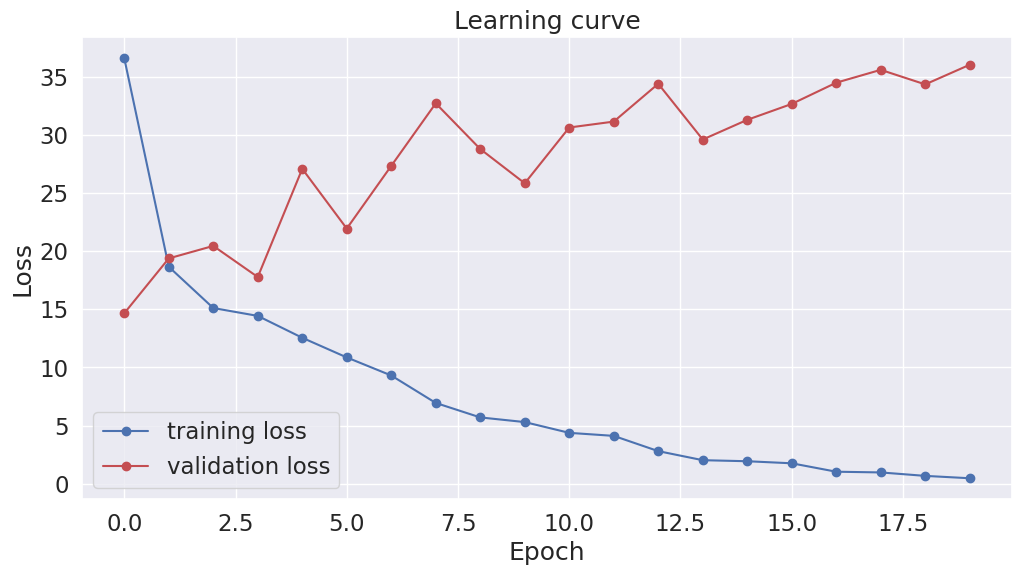

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


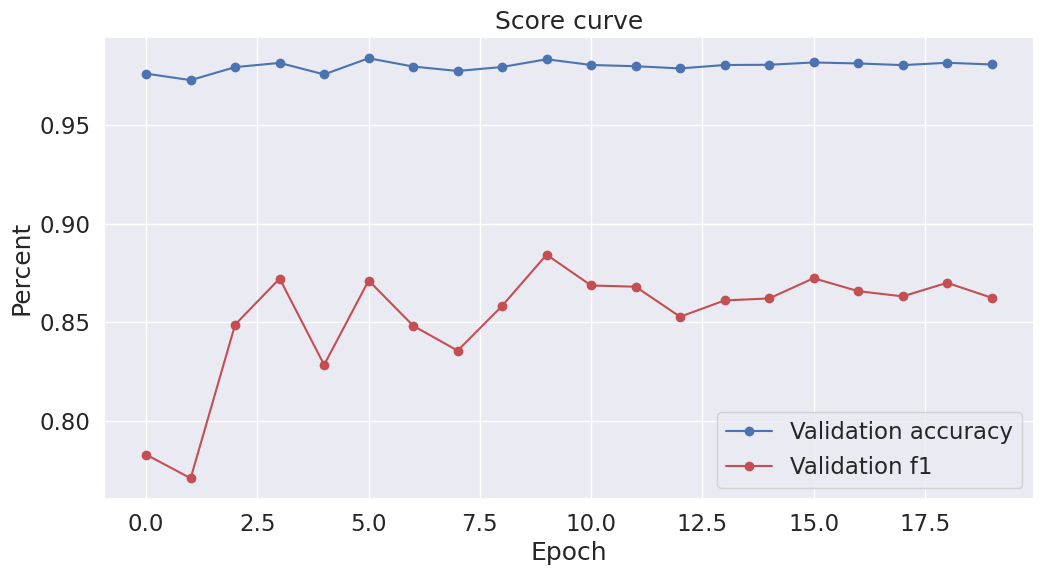

In [4]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(validation_accuracy, 'b-o', label="Validation accuracy")
plt.plot(validation_f1, 'r-o', label="Validation f1")
# Label the plot.
plt.title("Score curve")
plt.xlabel("Epoch")
plt.ylabel("Percent")
plt.legend()

plt.show()


In [5]:
model.eval()
# Reset the validation loss for this epoch.
devel_loss, devel_accuracy = 0, 0
nb_devel_steps, nb_devel_examples = 0, 0
predictions , true_labels = [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1].to(torch.bool), "token_type_ids": None,
                  "labels": batch[2]}

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(**inputs)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    # print(logits)
    label_ids = batch[2].to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    devel_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

devel_loss = devel_loss / len(test_dataloader)
print("Devel loss: {}".format(devel_loss))
pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                              for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
                              for l_i in l if tag_values[l_i] != "PAD"]
print("Devel Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
print("Devel F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
print(pred_tags)


Devel loss: 40.33321442604065
Devel Accuracy: 0.9778318158683481
Devel F1-Score: 0.8468664850136239
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FOLLICLE-NAME', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [92]:
test_sentence = """12-o-tetradecanoylphorbol-13-acetate (TPA), a tumor promoter, accelerates reentry of hair follicles into anagen phase. """
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
# print(output)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    print(token, label_idx)
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
# for token, label in zip(new_tokens, new_labels):
#     print("{}\t\t{}".format(label, token))

RuntimeError: The expanded size of the tensor (906) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [1, 906].  Tensor sizes: [1, 512]

In [23]:
tokens

['[CLS]',
 '12',
 '-',
 'o',
 '-',
 'tetradecanoylphorbol',
 '-',
 '13',
 '-',
 'acetate',
 '(',
 'TPA',
 ')',
 ',',
 'a',
 'tumor',
 'promoter',
 ',',
 'accelerates',
 'reentry',
 'of',
 'hair',
 'follicles',
 'into',
 'anagen',
 'phase',
 '.',
 '[SEP]']

In [19]:
new_tokens

['[CLS]',
 '12',
 '-',
 'o',
 '-',
 'tetradecanoylphorbol',
 '-',
 '13',
 '-',
 'acetate',
 '(',
 'TPA',
 ')',
 ',',
 'a',
 'tumor',
 'promoter',
 ',',
 'accelerates',
 'reentry',
 'of',
 'hair',
 'follicles',
 'into',
 'anagen',
 'phase',
 '.',
 '[SEP]']

In [20]:
new_labels

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-FOLLICLE-NAME',
 'I-FOLLICLE-NAME',
 'O',
 'O',
 'O',
 'O',
 'O']

In [12]:
import json
import os
def  get_entity_bio_offset(words, seq, id2tag):
    # 将一个句子里面的实体全部找出来，并改成[[tag1, startid, endid], [], []]的结构
    chunks = []  #chunks:[['BIO', 6, 7, 'follicle growth']]
    chunk = [-1, -1, -1, -1]  #chunk:['BIO', 9, 9, 'follicle growth']
    offset = 0
    full_word = []
    for index, tag in enumerate(seq):  #index:10 tag:'I-BIO-NAME'
        if words[index] in ("[CLS]", "[SEP]"):
            continue
        if not isinstance(tag, str):
            tag = id2tag[tag]
        if tag.startswith("B-"):
            if chunk[2] != -1:  # 保存上一个标签
                chunks.append(chunk)
            chunk = [-1, -1, -1, -1]
            chunk[0] = tag.split('-')[1]  # BIO
            if index == 1:
                chunk[1] =  offset
            else:
                chunk[1] = offset + 1
            chunk[2] = offset + len(words[index])   #9 modify 25
            chunk[3] = words[index]
            if index == len(seq) - 1:
                chunks.append(chunk)
        elif tag.startswith('I-') and chunk[1] != -1:
            _type = tag.split('-')[1]
            if _type == chunk[0]:
                if (words[index]) not in ('-', ',', '.', ':', '(' , ')', '/', '%', '[', ']'):
                    if (words[index]) == '\'' and words[index+1] =='s':
                        chunk[2] = offset + len(words[index]) + 1
                        chunk[3] += ' ' + words[index]
                    elif (words[index]) == '=' and words[index-1] in ('>','<'):
                        chunk[2] = offset + len(words[index]) + 1
                        chunk[3] += ' ' + words[index]
                    else:
                        if (words[index-1]) in ('-', '(' , '/', '['):
                            chunk[2] = offset + len(words[index]) + 1
                            chunk[3] += words[index]
                        else:
                            chunk[2] = offset + len(words[index]) + 1
                            chunk[3] += ' ' + words[index]
                elif (words[index]) in ('-', '/'): #  两侧无空格
                    chunk[2] = offset -1 + len(words[index]) + 1
                    chunk[3] = chunk[3].rstrip() + words[index]
                elif (words[index]) in (',', '.', ':', ')', '%', ']'): #  左无空格
                    chunk[2] = offset -1 + len(words[index]) + 1
                    chunk[3] = chunk[3].rstrip() + words[index]
                elif (words[index]) in ('(', '['): #  右无空格
                    chunk[2] = offset + len(words[index]) + 1
                    chunk[3] += ' ' + words[index]
            if index == len(seq) - 1:
                chunks.append(chunk)
        else:
            if chunk[2] != -1:
                chunks.append(chunk)
            chunk = [-1, -1, -1, -1]
        try:
            if (words[index]) not in ('-', ',', '.', ':', '(' , ')', '/', '%', '[', ']'):
                if (words[index]) == '\'' and words[index+1] =='s':
                    offset += -1 + len(words[index])
                elif (words[index]) == '=' and words[index-1] in ('>','<'):
                    offset += -1 + len(words[index]) + 1
                else:
                    offset += len(words[index]) + 1
            elif (words[index]) in ('-', '/'): #  两侧无空格
                offset += -1 + len(words[index])
            elif (words[index]) in (',', '.', ':', ')', '%', ']'): #  左无空格
                offset += -1 + len(words[index]) + 1
            elif (words[index]) in ('(', '['): #  右无空格
                offset += len(words[index])
            # # # offset += len(words[index]) + 1
            # # # 每次判断一下输入的单词是什么，如果是“,.:”这些的话offset就不需要左侧多加一位，另外，如果是第一个单词，也不需要
            # if words[index+1] == "," or words[index+1] == "." or words[index+1] == ":":
            #     offset += len(words[index])
            # else:
            #     offset += len(words[index]) + 1
            # #     offset += len(words[index])

        except:
            continue
    return chunks

def get_fulltext(token):
    output_text = ""
    for t in token:
        # .rstrip()用于去除字符串末尾的空格
        if t in ['[CLS]', '[SEP]']:
            continue
        if t not in ('-', ',', '.', ':', '(' , ')', '/', '%', '[', ']'):
            output_text += t + " "
        elif t in ('-','/'):
            output_text = output_text.rstrip() + t
        elif t in (',', '.', ':', ')', '%', ']'):
            output_text = output_text.rstrip() + t + ' '
        elif t in ('(', '['):
            output_text += t
    output_text = output_text.rstrip()
    return output_text

def split_paragraph_into_sentences(paragraph):
    sentences = []
    current_sentence = ""
    for char in paragraph:
        current_sentence += char
        if char == '.':
            sentences.append(current_sentence.strip())
            current_sentence = ""
    # Add any remaining sentence if there's any text left after the last period.
    if current_sentence:
        sentences.append(current_sentence.strip())
    return sentences

def output_result(token, pre_labels, true_tags_list, id2tag):
    folder = os.path.exists('My output results')  # 创建一个新的文件夹目录放置转换为BIO格式的文件
    if not folder:
        os.makedirs('My output results')
    words_list = token
    preds_list = pre_labels
    with open('My output results/bert_bilstm_crf_results.txt', 'w') as f:
        for words, preds in zip(words_list, preds_list):
            for word, pred in zip(words, preds):
                f.write('{} {}'.format(word, pred))
                f.write('\n')
            f.write('\n')  # 每一句的结束需要换行
    data = []
    for words, true_tags, preds in zip(words_list, true_tags_list, preds_list):
        true_entities = get_entity_bio_offset(words, true_tags, id2tag)
        true_entities_new = [str((true_entity[0], true_entity[1], true_entity[2], true_entity[3])) for true_entity in true_entities]
        pred_entities = get_entity_bio_offset(words, preds, id2tag)
        pred_entities_new = [str((pred_entity[0], pred_entity[1], pred_entity[2], pred_entity[3])) for pred_entity in pred_entities]
        data.append({"text": get_fulltext(words), "ent_predict": "; ".join(pred_entities_new), "golen_label":
            "; ".join(true_entities_new)})
    data_json = json.dumps(data, indent=2)
    with open('My output results/bert_bilstm_crf.json', 'w', newline='\n') as f:
        f.write(data_json)

# text = "12-o-tetradecanoylphorbol-13-acetate (TPA), a tumor promoter, accelerates reentry of hair follicles into anagen phase."
# token = [['[CLS]','12','-','o','-','tetradecanoylphorbol','-','13','-','acetate','(','TPA',')',',','a','tumor','promoter',',','accelerates','reentry','of','hair','follicles','into','anagen','phase','.','[SEP]']]
# pre_labels = [['O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','B-FOLLICLE-NAME','I-FOLLICLE-NAME','O','O','O','O','O']]
# true_labels = [['O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','B-FOLLICLE-NAME','I-FOLLICLE-NAME','O','O','O','O','O','O','O','O','O','Ob']]
# output_result(token, pre_labels, true_labels, tag2idx)

In [13]:
# 读取待预测数据
# 读取TXT文件
with open('predication_data/preprocess_abstract_new.txt', 'r') as file:
    lines = file.readlines()
# 获取偶数行数据
even_lines = lines[1::2]
# 将数据转换为DataFrame
df = pd.DataFrame(even_lines, columns=['Data'])

total_token_data = []
total_label_data = []
for index, row in df.iterrows():
    sentences = split_paragraph_into_sentences(row['Data'])
    predictions_raw_token_data = []
    predictions_raw_label_data = []
    for sentence in sentences:
        test_sentence = sentence
        tokenized_sentence = tokenizer.encode(test_sentence)
        input_ids = torch.tensor([tokenized_sentence]).cuda()
        with torch.no_grad():
            output = model(input_ids)
        # print(output)
        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            # print(token, label_idx)
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)
        predictions_raw_token_data.extend(new_tokens)
        predictions_raw_label_data.extend(new_labels)
    total_token_data.append(predictions_raw_token_data)
    total_label_data.append(predictions_raw_label_data)
# print(total_token_data)
output_result(total_token_data, total_label_data, total_label_data, tag2idx)

In [45]:
# predictions_raw_token_data = []
# predictions_raw_label_data = []
# # 遍历每行数据
# for index, row in df.iterrows():
#     test_sentence = row['Data'][:1500]
#     tokenized_sentence = tokenizer.encode(test_sentence)
#     input_ids = torch.tensor([tokenized_sentence]).cuda()
#     with torch.no_grad():
#         output = model(input_ids)
#     # print(output)
#     label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
#     # join bpe split tokens
#     tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
#     new_tokens, new_labels = [], []
#     for token, label_idx in zip(tokens, label_indices[0]):
#         # print(token, label_idx)
#         if token.startswith("##"):
#             new_tokens[-1] = new_tokens[-1] + token[2:]
#         else:
#             new_labels.append(tag_values[label_idx])
#             new_tokens.append(token)
#     predictions_raw_token_data.append(new_tokens)
#     predictions_raw_label_data.append(new_labels)
#
# # print('predictions_raw_token_data', predictions_raw_token_data)


In [110]:
# output_result(predictions_raw_token_data, predictions_raw_label_data, predictions_raw_label_data, tag2idx)

In [36]:
model.save_pretrained("biobert_model_ner")